In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import namedtuple
from matplotlib.collections import PatchCollection
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import math
import json
from PIL import Image
import numpy as np

In [9]:
Rectangle = namedtuple('Rectangle', 'x y w h')

In [10]:
# метод для получения ограничивающей рамки для множества прямоугольников
def get_bbox(*rects):
    xmin = 1e9
    ymin = 1e9
    xmax = -1e9
    ymax = -1e9
    for rect in rects:
        xmin = min(xmin, rect[0], rect[0]+rect[2])
        ymin = min(ymin, rect[1], rect[1]+rect[3])
        xmax = max(xmax, rect[0], rect[0]+rect[2])
        ymax = max(ymax, rect[1], rect[1]+rect[3])
        
    return Rectangle(xmin, ymin, xmax-xmin, ymax-ymin)

In [88]:
# проверка, пересекаются ли рамки
def bboxes_imtersects(a, b):
    return abs((a.x + a.w/2) - (b.x + b.w/2)) * 2 < (a.w + b.w) and \
           abs((a.y + a.h/2) - (b.y + b.h/2)) * 2 < (a.h + b.h)

In [11]:
# специальная метрика для расчета "расстояния" между прямоугольниками
def bounded_rect_distance(a, b, max_bbox_size):
    bbox = get_bbox(a, b)
    if bbox.w > max_bbox_size or bbox.h > max_bbox_size:
        return 1e9
    return max(bbox[2]-a[2], bbox[2]-b[2], bbox[3]-a[3], bbox[3]-b[3])

In [30]:
# преобразование словаря в прямоугольник
def coords_to_rect(c):
    return Rectangle(c["x1"], c["y1"], c["x2"]-c["x1"], c["y2"]-c["y1"])

In [38]:
IMAGE_PATH = "/home/denis/Godis/data/detailed_photos/0047_20160609_110125_873.jpg"
image = np.array(Image.open(IMAGE_PATH), dtype=np.uint8)

In [39]:
coords = [
    { "x1": 1386, "y1": 1890, "x2": 1448, "y2": 1962 },
    { "x1": 1599, "y1": 1935, "x2": 1646, "y2": 1992 },
    { "x1": 2481, "y1": 1948, "x2": 2505, "y2": 1976 },
    { "x1": 1981, "y1": 1962, "x2": 2026, "y2": 2085 },
    { "x1": 2318, "y1": 1961, "x2": 2370, "y2": 2069 },
    { "x1": 2575, "y1": 1961, "x2": 2624, "y2": 2091 },
    { "x1": 2472, "y1": 1952, "x2": 2510, "y2": 2093 },
    { "x1": 2518, "y1": 1951, "x2": 2565, "y2": 2117 },
    { "x1": 1794, "y1": 1696, "x2": 1841, "y2": 1759 },
    { "x1": 1954, "y1": 1798, "x2": 1989, "y2": 1835 },
    { "x1": 2484, "y1": 1841, "x2": 2509, "y2": 1871 },
    { "x1": 2552, "y1": 1790, "x2": 2588, "y2": 1838 },
    { "x1": 2220, "y1": 2002, "x2": 2247, "y2": 2054 },
    { "x1": 3186, "y1": 1348, "x2": 3302, "y2": 1496 },
    { "x1": 1282, "y1": 1364, "x2": 1382, "y2": 1528 },
    { "x1": 2810, "y1": 1929, "x2": 2902, "y2": 2201 },
    { "x1": 2688, "y1": 1942, "x2": 2776, "y2": 2185 },
    { "x1": 2070, "y1": 1012, "x2": 2226, "y2": 1160 }
]
rects = [coords_to_rect(c) for c in coords]

## Визуализация исходных данных

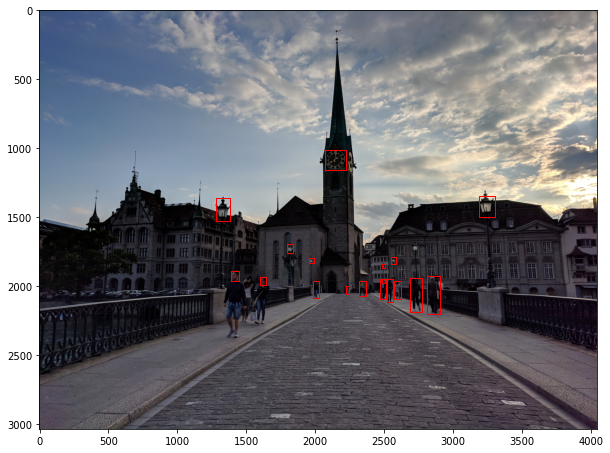

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))

collection = PatchCollection([
    patches.Rectangle((r.x, r.y), r.w, r.h) for r in rects
], linewidth=1, edgecolor='r', facecolor='none')

ax.imshow(image)
ax.add_collection(collection)

## Разбиение прямоугольников на кластеры

Для кластеризации используется иерархическая кластеризация, метод полной связи. Для этого вводится метрика - расстояние между прямоугольниками (см. выше). Это метрика, по сути, определяет, насколько больше станет ограничивающая рамка кластеров, если два кластера объединятся. При этом еще используется параметр, который определяет, насколько большим может быть измерение рамки. В данном примере выбрано 1500 пикселей.

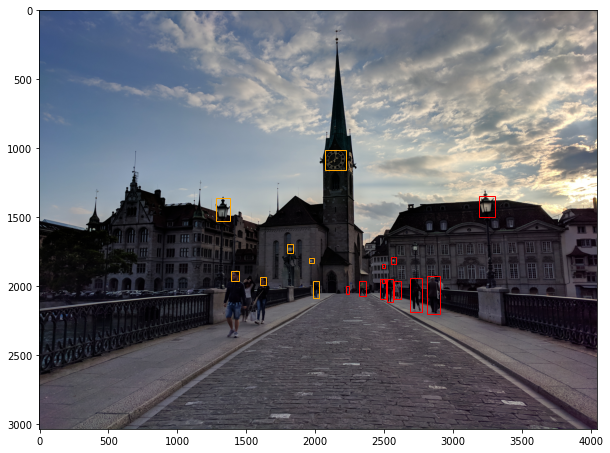

In [103]:
rect_dist = lambda a, b: bounded_rect_distance(a, b, 1500)
linked = linkage(rects, 'complete', metric=rect_dist);

clusters = fcluster(linked, 1e8, criterion="distance") - 1
colors = ["r", "g", "b", "yellow", "pink", "white", "cyan", "gray", "orange"]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
for r, cluster in [*zip(get_object_rects(markup[N]["markup"]), clusters)]:
    rect = patches.Rectangle((r.x, r.y), r.w, r.h, edgecolor=colors[cluster-1], linewidth=1, facecolor='none')
    ax.add_patch(rect)

## Работа с кластерами

Разбиение всех прямоугольников на отдельные массивы

In [67]:
rect_clusters = []
for i in range(clusters.max() + 1):
    mask = clusters == i
    _rects = [r for j, r in enumerate(rects) if mask[j]]
    rect_clusters.append(_rects)

Расчет ограничивающих рамок кластеров

In [68]:
bboxes = [get_bbox(*rc) for rc in rect_clusters]

Добавление некоторого внешнего отступа для кластера

In [69]:
margin = 50
for i in range(len(bboxes)):
    b = bboxes[i]
    bboxes[i] = Rectangle(b.x - margin, b.y - margin, b.w + margin * 2, b.h + margin * 2)

Визуализация результата

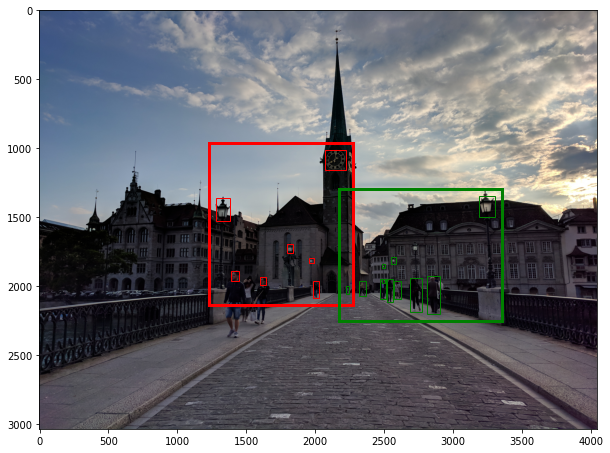

In [70]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
for i, bbox in enumerate(bboxes):
    bbox_pacth = patches.Rectangle((bbox.x, bbox.y),
                                    bbox.w, bbox.h, edgecolor=colors[i],
                                    linewidth=3, facecolor="none")
    for r in rect_clusters[i]:
        rect_pacth = patches.Rectangle((r.x, r.y), r.w, r.h,
                                       edgecolor=colors[i], linewidth=1, facecolor="none")
        ax.add_patch(rect_pacth)
    ax.add_patch(bbox_pacth)

Разбиение изображения на фрагменты и поиск прямоугольников, которые относятся к данному фрагменту

In [100]:
fragments = []
f_rects = []
for i, bbox in enumerate(bboxes):
    frag = image[bbox.y:bbox.y+bbox.h, bbox.x:bbox.x+bbox.w]
    fragments.append(frag)
    f_rects.append([r for r in rects if bboxes_imtersects(bbox, r)])

## Финальный результат

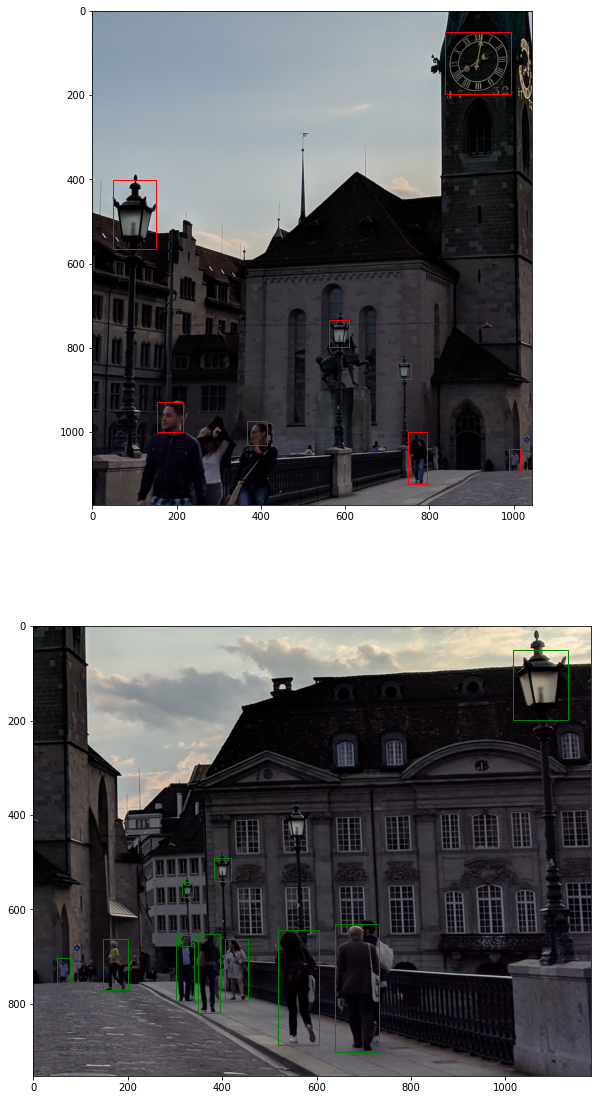

In [102]:
fig, axes = plt.subplots(len(bboxes), figsize=(10, 20))
for i, bbox in enumerate(bboxes):
    frag = fragments[i]
    axes[i].imshow(frag)
    for r in f_rects[i]:
        r_patch = patches.Rectangle((r.x - bbox.x, r.y - bbox.y),
                                    r.w, r.h, edgecolor=colors[i], linewidth=1, facecolor="none")
        axes[i].add_patch(r_patch)